# PROYECTO INDIVIDUAL 1 MLOps: EDA y MLOps

In [1]:
#Importacion de librerias
%matplotlib inline
import numpy as np
from numpy import mean, var
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from math import sqrt
import ast

from sklearn.feature_extraction.text import CountVectorizer #para convertir las caracteristicas combinadas en una matriz
from sklearn.neighbors import NearestNeighbors # para crear un modelo que pueda encontrar los vecinos mas cercanos en un espacio dado

# HashingVectorizer es una clase que convierte una coleccion de documentos de texto en una matriz de ocurrencias de tokens. 
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
#Leemos el archivo csv como df
df=pd.read_csv('movies_dataset.csv')

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13564\1321045274.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('movies_dataset.csv')


In [3]:
df.drop(columns=['video', 'imdb_id', 'adult', 'original_title', 'vote_count', 'poster_path', 'homepage'], inplace = True)
df.columns

Index(['belongs_to_collection', 'budget', 'genres', 'id', 'original_language',
       'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average'],
      dtype='object')

## 4) EDA

In [4]:
# Convertimos las columnas 'popularity' y 'vote_average' a float
df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')
df['vote_average'] = pd.to_numeric(df['vote_average'], errors='coerce')


In [5]:
# Resumen estadistico de las columnas numericas
df.describe()

,popularity,revenue,runtime,vote_average
count,45460.000000,4.546000e+04,45203.000000,45460.000000
mean,2.921478,1.120935e+07,94.128199,5.618207
std,6.005414,6.433225e+07,38.407810,1.924216
min,0.000000,0.000000e+00,0.000000,0.000000
25%,0.385948,0.000000e+00,85.000000,5.000000
50%,1.127685,0.000000e+00,95.000000,6.000000
75%,3.678902,0.000000e+00,107.000000,6.800000
max,547.488298,2.787965e+09,1256.000000,10.000000


In [6]:
# Resumen de las columnas no numericas 
df.describe(include=['O'])

,belongs_to_collection,budget,genres,id,original_language,overview,production_companies,production_countries,release_date,spoken_languages,status,tagline,title
count,4494,45466,45466,45466,45455,44512,45463,45463,45379,45460,45379,20412,45460
unique,1698,1226,4069,45436,92,44307,22708,2393,17336,1931,6,20283,42277
top,"{'id': 415931, 'name': 'The Bowery Boys', 'pos...",0,"[{'id': 18, 'name': 'Drama'}]",141971,en,No overview found.,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2008-01-01,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Cinderella
freq,29,36573,5000,3,32269,133,11875,17851,136,22395,45014,7,11


In [7]:
# Convertimos la columna 'genres' de string a lista de diccionarios
df['genres'] = df['genres'].apply(ast.literal_eval)
# Extraemos el nombre de cada genero y cramos una nueva columna con la lista de nombres de generos
df['genre_names'] = df['genres'].apply(lambda x: [d['name'] for d in x])
# Expandimos la lista de nombres de géneros
generos_expandidos = df['genre_names'].explode()
# Contamos la frecuencia de cada valor en la columna 'genre_names'
conteo_generos = generos_expandidos.value_counts()
# Eliminamos los géneros que solo aparecen una vez
conteo_generos = conteo_generos[conteo_generos > 1]

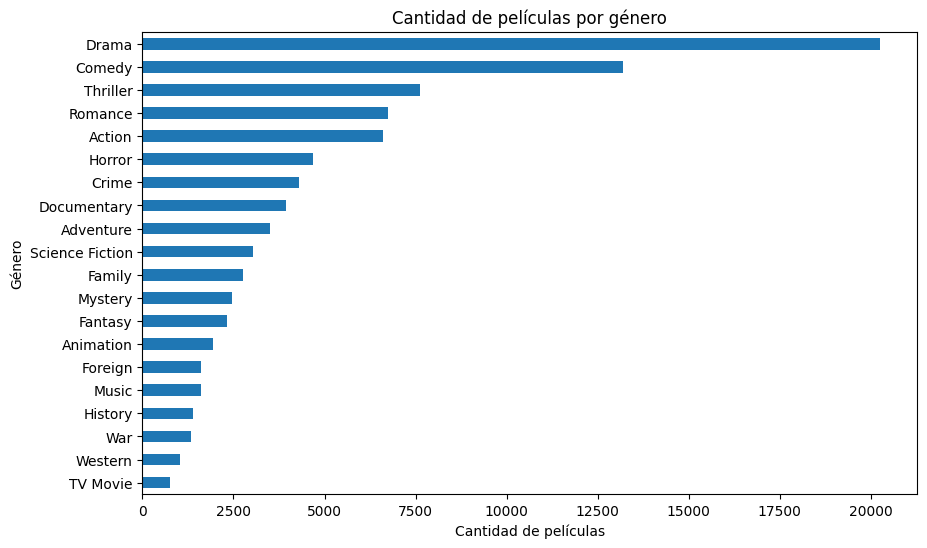

In [8]:
# Grafico para ver la cantidad de peliculas por genero
conteo_generos = conteo_generos.sort_values()  # Ordenamos los géneros por cantidad de películas

plt.figure(figsize=(10,6)) 
conteo_generos.plot(kind='barh')  # Creamos un gráfico de barras horizontales
plt.title('Cantidad de películas por género')  # Añadimos un título al gráfico
plt.xlabel('Cantidad de películas')  # Añadimos un título al eje x
plt.ylabel('Género')  # Añadimos un título al eje y
plt.show()  # Mostramos el gráfico

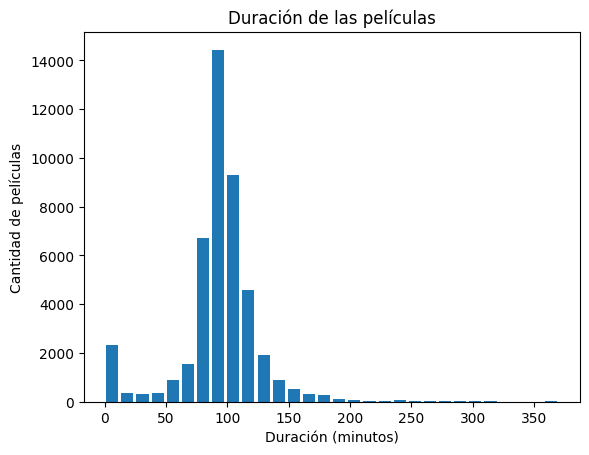

In [9]:
# Duracion de las peliculas
df_filtered = df[(df['runtime'] >= 0) & (df['runtime'] <= 380)]
df_filtered['runtime'].plot(kind='hist', rwidth=0.8, bins=30)

plt.title('Duración de las películas')
plt.xlabel('Duración (minutos)')
plt.ylabel('Cantidad de películas')

plt.show()

In [10]:
# Hacemos las mismas transformaciones que en la sección de endpoints a las columna 'release_date':
# Formato AAAA-mm-dd, además creamos la columna release_year donde extraerán el año de la fecha de estreno.
# Le damos el formato de fecha a todos los valores de la columna y los que no, le asignamos la etiqueta de nulo
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Se asegura que todos los registros tengan el mismo formato de fecha AAAA-MM-DD
df['release_date'] = pd.to_datetime(df['release_date']).dt.strftime('%Y-%m-%d')

# Se identifican la cantidad de datos nulos de la columna 'release_date' 
df['release_date'].isnull().sum()
# Eliminamos los registros con nulos 
df = df.dropna(subset = ['release_date'])

# Controlamos para verificar que no existan nulos
df['release_date'].isnull().sum()
# Creamos una nueva columna 'release_year' que va a contener unicamnete el dato de año de la columna 'release_date' 
df['release_date'] = pd.to_datetime(df['release_date'])
df['release_year']=df['release_date'].dt.year

# Hacemos control sobre los cambios
df[['release_date','release_year']].tail(10)

,release_date,release_year
45455,1972-01-01,1972
45456,1946-03-29,1946
45457,2000-10-22,2000
45458,2000-10-03,2000
45459,1995-01-01,1995
45460,1991-05-13,1991
45462,2011-11-17,2011
45463,2003-08-01,2003
45464,1917-10-21,1917
45465,2017-06-09,2017


Text(0.5, 1.0, 'Número de películas por año')

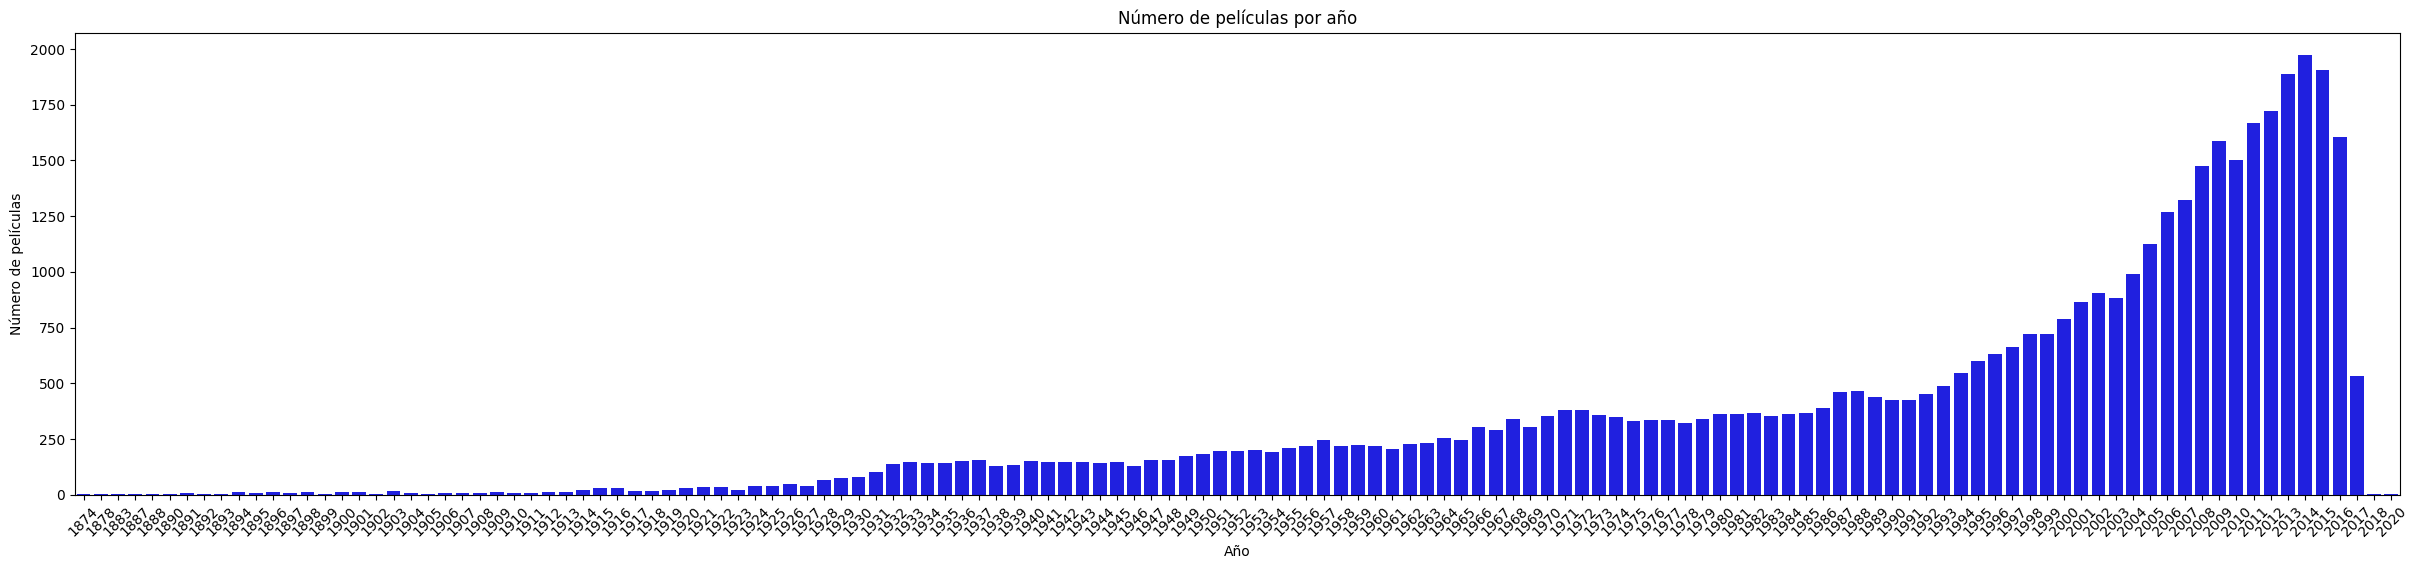

In [11]:
movies_per_year = df['release_year'].value_counts().sort_index()
plt.figure(figsize=(30, 6))
sns.barplot(x=movies_per_year.index, y=movies_per_year.values, color='b')
plt.xticks(rotation=45)

plt.xlabel('Año')
plt.ylabel('Número de películas')
plt.title('Número de películas por año')


<Axes: xlabel='release_year'>

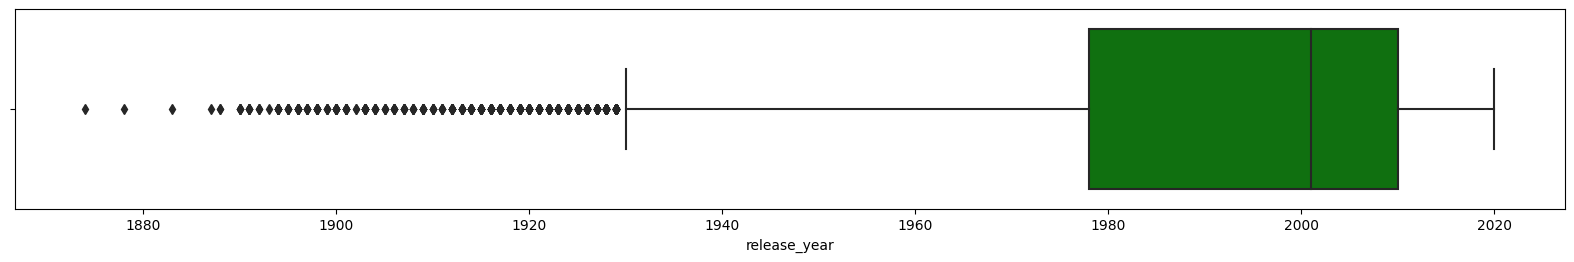

In [12]:
plt.figure(figsize= (20,15))
plt.subplot(5,1,1)
sns.boxplot(x= df.release_year, color='green')

In [13]:
# Filtro las películas desde 1930, ya que no hay tantas y además quizás no estarán relacionadas entre sí
df = df[df['release_year'] >= 1970]

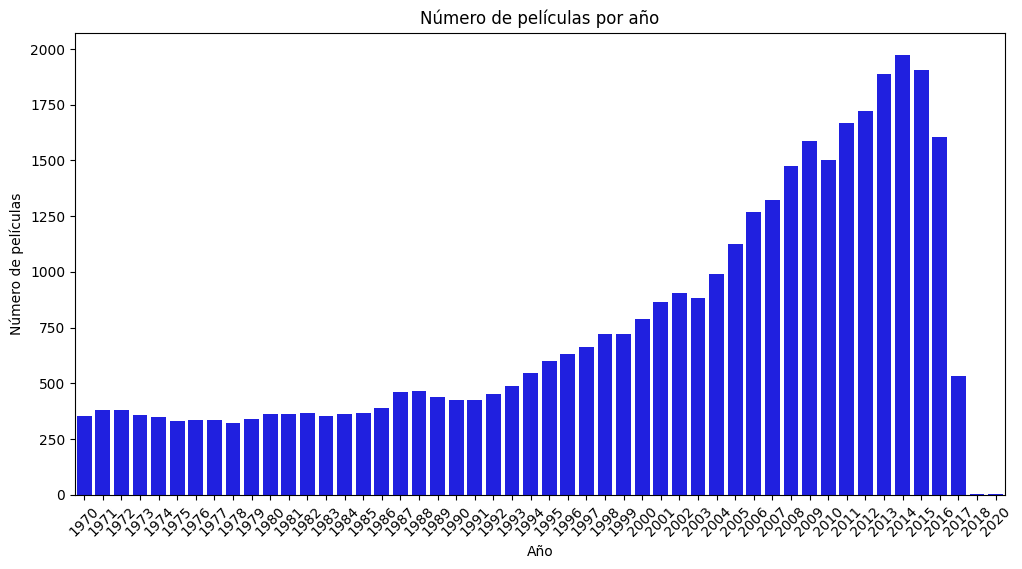

In [14]:
movies_per_year = df['release_year'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.barplot(x=movies_per_year.index, y=movies_per_year.values, color='b')
plt.xticks(rotation=45)

plt.xlabel('Año')
plt.ylabel('Número de películas')
plt.title('Número de películas por año')

plt.show()

## Machine learning

In [15]:
# Instalamos la libreria nltk porque es muy útil a la hora de trabajar con texto y realizar tareas relacionadas con el procesamiento del lenguaje natural.
# pip install nltk
# Importamos la libería al inicio de este archivo.

In [16]:
# Hay valores flotantes en la columna overview, los convertimos a string.
df['overview'] = df['overview'].astype(str)

In [17]:
# Concatenamos todas las descripciones de las películas en una sola cadena de texto
# Utilizamos astype para asegurarnos de que todos los valores siguen siendo cadenas de texto
text = ' '.join(df['overview'].astype(str))


In [18]:
df.shape

(37087, 19)

In [19]:
# Eliminamos los duplicados basandonos en la columna 'title'
df = df.drop_duplicates(subset='title')

# Recreamos el indice de los titulos luego de eliminar los duplicados
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

df.shape
# Notamos que habían películas con el mismo título0

(34969, 19)

In [20]:
# Debido a que el dataset contiene muchos registros decidí ordenar los datos a través de las columnas 'popularity', 
# samplear los primeros 10000 valores y luego hacer lo mismo con 'vote_average', pero para los primeros 5000 valores.
# Esto lo hago para que en la API, el usuario a la hora de buscar peliculas no reciba un feedback con peliculas menos conocidas. 
# Estas dos columnas permiten recortar el dataset por peliculas con mayor popularidad o con un mayor puntaje de reseña.

In [21]:
# Ordenamos el df por popularidad y tomamos las primeras 10000 filas
df_popular = df.sort_values(by='popularity', ascending=False).head(10000).reset_index(drop=True)

# A df con filas ordenadas por popularidad, lo ordeno según los votos y tomo las primeras 5000 filas
df_highly_rated = df_popular.sort_values(by='vote_average', ascending=False).head(5000).reset_index(drop=True)

print('Tamaño del df filtrado por popularity:', df_popular.shape)
print('Tamaño del df filtrado por votos:', df_highly_rated.shape)


Tamaño del df filtrado por popularity: (10000, 19)
Tamaño del df filtrado por votos: (5000, 19)


In [22]:
# Cosine_similarity es una función que calcula la similitud del coseno. La similitud del coseno es una 
# metrica utilizada para determinar cuan similares son dos vectores.

# Aseguramos que los datos de la columna 'overview', 'genres' y 'production_companies' sean strings
df_highly_rated['overview'] = df_highly_rated['overview'].fillna('').astype('str')
df_highly_rated['genres'] = df_highly_rated['genres'].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, list) else '')
# Reemplazar los valores nulos con cadenas vacias
df_highly_rated['production_companies'] = df_highly_rated['production_companies'].fillna('')
df_highly_rated['production_companies'] = df_highly_rated['production_companies'].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, list) else x)

# Creamos una nueva columna llamada 'combined_features' que es una combinacion de las columnas 'overview', 'genres' y 
# 'production_companies'. Esta columna se usara para calcular la similitud entre diferentes peliculas.
df_highly_rated['combined_features'] = df_highly_rated['overview'] + ' ' + df_highly_rated['genres'] + ' ' + df_highly_rated['production_companies']

# Convertimos todos los textos a minusculas para evitar duplicados
df_highly_rated['combined_features'] = df_highly_rated['combined_features'].str.lower()

# Inicializamos el HashingVectorizer
hash_vectorizer = HashingVectorizer(stop_words='english', n_features=2000)
# De esta manera evitamos que las palabras mas comunes afecten a nuestro procesamiento de datos
# y evitamos que se generen vectores mas grandes

# Aprende el vocabulario de 'combined_features' y transforma 'combined_features' en una matriz de vectores
hash_matrix = hash_vectorizer.fit_transform(df_highly_rated['combined_features'])

# Calculamos la similitud del coseno
cosine_sim = cosine_similarity(hash_matrix)

# Creamos un indice con los titulos de las peliculas
indices = pd.Series(df_highly_rated.index, index=df_highly_rated['title']).drop_duplicates()

In [23]:
df_highly_rated.head(1)

,belongs_to_collection,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,genre_names,release_year,combined_features
0,"{'id': 477208, 'name': 'DC Super Hero Girls Co...",0,"{'id': 16, 'name': 'Animation'}",460135,en,"When Supergirl, Wonder Woman, Batgirl, Bumbleb...",8.413734,"[{'name': 'Warner Bros. Animation', 'id': 2785}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2017-08-30,0.0,0.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,LEGO DC Super Hero Girls: Brain Drain,10.0,[Animation],2017,"when supergirl, wonder woman, batgirl, bumbleb..."


In [24]:
df_highly_rated.to_csv('movies_recommend.csv', index=False)

### Optimizamos el código ya que hemos tenido inconvenientes con la API en Render

In [25]:
# Al correr el código Render tenía un problema de memoria, por lo que se tuvo que optimizar la función

In [26]:
# Nos aseguramos de que estamos trabajando con los datos exportados del df_highly_rated
df_highly_rated = pd.read_csv('movies_recommend.csv') 

#  En esta matriz, cada fila representa una película y cada columna 
# representa un termino en las caracteristicas combinadas
cv = CountVectorizer(stop_words='english', max_features=5000)
count_matrix = cv.fit_transform(df_highly_rated['combined_features'])

# Creamos un modelo para encontrar los vecinos mas cercanos en un espacio de caracterisicaa
nn = NearestNeighbors(metric='cosine', algorithm='brute')
nn.fit(count_matrix)

# Creamos un indice de titulos de peliculas y eliminamos los duplicados
indices = pd.Series(df_highly_rated.index, index=df_highly_rated['title']).drop_duplicates()


In [27]:
def recomendacion(title):
    '''Ingresas un nombre de pelicula y te recomienda las similares en una lista
    ''' 
    # Verifica si el titulo ingresado se encuentra en el df
    if title not in df_highly_rated['title'].values:
        return 'La pelicula no se encuentra en el conjunto de la base de datos.'
    else:
        # Si el título esta en el df, encuentra su indice
        index = indices[title]

        # Obtiene las puntuaciones de similitud de las 5 peliculas más cercanas
        distances, indices_knn = nn.kneighbors(count_matrix[index], n_neighbors=6)  # indica que queremos encontrar las 6 peliculas más similares, incluyendo la pelicula dada

        # Obtiene los indices de las peliculas
        movie_indices = indices_knn[0][1:]  # Se omite el primer indice (la pelicula misma) con [1:]

        # Devuelve las 5 peliculas mas similares
        return df_highly_rated['title'].iloc[movie_indices].tolist()

In [28]:
print(recomendacion('Toy Story'))

['Toy Story 3', 'Toy Story 2', 'Small Fry', 'Hawaiian Vacation', "A Bug's Life"]
